In [ ]:
import pandas as pd
import math
import datetime
import statistics
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
from collections import OrderedDict
from matplotlib.dates import DateFormatter

In [ ]:
data = pd.read_excel("/content/rout (1).xlsx")

In [ ]:
depot_name = ['Colaba depot','Backbay depot','Mumbai Central depot','Worli depot', 'KalaKilla depot','Wadala depot','Dharavi depot','Dindoshi depot','Kurla depot','Bandra depot','Santacruz depot','Oshiwara depot','Poisar depot','Gorai depot','Malvani depot','Malad depot','Anik depot','Prateeksha Nagar depot','Deonar depot','Shivaji Nagar depot','Ghatkopar depot','Vikhroli depot', 'Magathane depot', 'Mulund depot' ]
# 'Majas depot' ,'Goregaon depot',  'Marol depot'
def hour_to_str(itime):
  tr =  str(math.trunc(itime)) + ':' + str(int(round((itime%1)*300/5)))
  itime = math.trunc(itime) + (itime%1)*3/5
  s=str(itime)
  clean_time = s.replace(".",":")

  if ( math.trunc(itime)<10) :
    clean_time = '0'+clean_time
    tr = '0' + tr
  clean_time  = clean_time[:5]
  if (len(clean_time)<5):
    clean_time+='0'

  return clean_time
charging_time_factor = 0.0
max_km=200
charge_full_time=6

def Factor_charging_time(charge_full_time):
  sum=0;
  for i in range(0,25):
      sum+=1/((2*(i/25)) +1.25);
  sum+=55/3.25;
  for i in range (80,100):
      sum+=1/(11.25 - (0.1*i));
  return charge_full_time/sum;

charging_time_factor = Factor_charging_time(charge_full_time)

In [ ]:
wait_queue_len = { depot: {} for depot in depot_name }
energy = {depot: {} for depot in depot_name}
for depot in depot_name:
  wait_queue_len[depot] = defaultdict(lambda: 0, wait_queue_len[depot])
  energy[depot] = defaultdict(lambda: 0, energy[depot])

In [ ]:
depotToBuses = {}
depotToBuses = defaultdict(lambda: [], depotToBuses)
total_buses = {}
total_buses = defaultdict(lambda: 0, total_buses)

In [ ]:
for depot in depot_name:
  listOfNumBuses = []
  print(depot)
  for queue_len in range(1, 100):

  # total_buses = 0
    src = data[(data['Source Depot'] == depot)]
    dest = data[(data['Destination Depot'] == depot)]

    src.index = [i for i in range(len(src))]
    dest.index = [i for i in range(len(dest))]

    src_num = src['Bus Number'].count()
    dest_num = dest['Bus Number'].count()

    src_dict = {}
    src_dict = defaultdict(lambda: 0, src_dict)

    for i in range(0,src_num):
      temp2 = [x.strip() for x in src['Departure From Source'][i].split(',')]
      temp2.pop()
      for i in temp2:
        src_dict["{}".format(i)] += 1

    for i in range(0,dest_num):
      temp2 = [x.strip() for x in dest['Departure From Destination'][i].split(',')]
      temp2.pop()
      for i in temp2:
        src_dict["{}".format(i)] += 1

    src_dict_final = OrderedDict(sorted(src_dict.items()))

    bus_queue = []
    out_times = []
    merged_list = []

    def add_to_queue(arr_time, charge_time):
      if(len(bus_queue) < queue_len):
        bus_queue.append(arr_time + charge_time)
      else:
        queue_top = bus_queue[0]
        out_times.append(hour_to_str(queue_top))
        bus_queue.pop(0)
        bus_queue.append(max(arr_time, queue_top) + charge_time)
      bus_queue.sort()

    def precompute_and_queueing(s,distance,max_km,charge_full_time,time_taken):
      initial=s
      clean_time = s.replace(":",".")
      itime = float(clean_time);
      itime = math.trunc(itime) + (itime%1)*5/3
      itime += float(time_taken)/60

      charge_consumed = distance*100/max_km
      time_to_charge=(charge_consumed) * charging_time_factor/3.25

      merged_list.append([itime, time_to_charge])
      # addToQueue(itime, time_to_charge)

    src_num = src['Bus Number'].count()
    dest_num = dest['Bus Number'].count()
    ready_dict = {}
    ready_dict = defaultdict(lambda: 0, ready_dict)
    src_dict = {}
    src_dict = defaultdict(lambda: 0, src_dict)

    # temp_dict = {}
    # temp_dict = defaultdict(lambda: 0, temp_dict)

    for i in range(0,src_num):
      temp2 = [x.strip() for x in src['Departure From Destination'][i].split(',')]
      dist = [x.strip() for x in src['Distance'][i].split(' ')]
      temp2.pop()
      dist.pop()
      distance = dist[0]
      time_taken = src['Journey Time'][i]
      if time_taken == "Not available":
        time_taken = int(round(float(distance)/18 * 60,0))
      for i in temp2:
        precompute_and_queueing(i[:5],float(distance),max_km,charge_full_time,int(time_taken))

    for i in range(0,dest_num):
      temp2 = [x.strip() for x in dest['Departure From Source'][i].split(',')]
      dist = [x.strip() for x in dest['Distance'][i].split(' ')]
      temp2.pop()
      dist.pop()
      distance = dist[0]
      time_taken = dest['Journey Time'][i]
      if time_taken == "Not available":
        time_taken = int(round(float(distance)/18 * 60,0))
      for i in temp2:
        precompute_and_queueing(i[:5],float(distance),max_km,charge_full_time,int(time_taken))
    merged_list = sorted(merged_list, key=lambda x: x[0]*(charge_full_time+1)+x[1])
    # print(merged_list)
    wait_queue = []

    while len(merged_list) != 0:
      arr_time= merged_list[0][0]
      charge_time = merged_list[0][1]
      if(len(bus_queue) < queue_len):
        # print("ji")
        del merged_list[0]
        bus_queue.append(arr_time + charge_time)
      else:
        bus_queue.sort()
        queue_top = bus_queue[0]
        # out_times.append(hour_to_str(queue_top))
        # bus_queue.pop(0)
        x = 0
        while len(merged_list) != 0:
          if(merged_list[0][0] >  queue_top):
            break
          if len(bus_queue)>1:
            if (merged_list[0][0] + merged_list[0][1])<bus_queue[-1]:
              last = bus_queue.pop()
              bus_queue.append(merged_list[0][0] + merged_list[0][1])
              bus_queue.sort()
              queue_top = bus_queue[0]
              merged_list[0][1] = last - merged_list[0][0]


          wait_queue.append(merged_list[0])
          x +=1

          del merged_list[0]

        bus_queue.sort()
        queue_top = bus_queue[0]
        out_times.append(hour_to_str(queue_top))
        bus_queue.pop(0)

        wait_queue_len[depot][queue_top] += x

        if len(wait_queue) != 0:
          wait_queue.sort(key = lambda x: x[1])                                  #####################################################

          bus_queue.append(queue_top  + wait_queue[0][1])
          del wait_queue[0]
          bus_queue.sort()


    wait_queue.sort(key = lambda x: x[1])                                       ##################################################
    for [itime, time_to_charge] in wait_queue:
      # out_times.append(hour_to_str(itime+time_to_charge))
      add_to_queue(itime, time_to_charge)

    for bus in bus_queue:
      out_times.append(hour_to_str(bus))

    for tme in out_times:
        c = 0
        for i in range(len(tme)):
          if tme[i] ==':':
            c = i
            break
        if c == 2:
          ready_dict["{}".format(tme)] += 1

    ready_dict_final = OrderedDict(sorted(ready_dict.items()))

    final_dict = {}
    final_dict = defaultdict(lambda: 0, final_dict)
    final_dict = ready_dict_final.copy()

    for key,value in src_dict_final.items():
      if key in final_dict.keys():
        final_dict[key] -= value
      else:
        final_dict[key] = -1*value
    final_dict_new = OrderedDict(sorted(final_dict.items()))
    # final_dict_new
    sum=0
    for key, value in final_dict_new.items():
      sum += value
      final_dict_new[key]=sum
    min_val = 0
    for key, value in final_dict_new.items():
      min_val = min(min_val,value)
    # print(depot)
    end_val = final_dict_new[list(final_dict_new.keys())[-1]]


    buses = (-1*min_val)
    # print(min_val, end_val)
    # buses
    depotToBuses[depot].append(buses)

    listOfNumBuses.append(buses)
    total_buses[queue_len] += buses

  # print(depot, end = ' - ')
  # print(listOfNumBuses[0])

Colaba depot
Backbay depot
Mumbai Central depot
Worli depot
KalaKilla depot
Wadala depot
Dharavi depot
Dindoshi depot
Kurla depot
Bandra depot
Santacruz depot
Oshiwara depot
Poisar depot
Gorai depot
Malvani depot
Malad depot
Anik depot
Prateeksha Nagar depot
Deonar depot
Shivaji Nagar depot
Ghatkopar depot
Vikhroli depot
Magathane depot
Mulund depot


In [ ]:
for depot in depot_name:
  print(depotToBuses[depot][60])

124
144
204
153
105
117
124
170
71
102
96
172
47
211
129
69
223
136
171
223
101
79
138
148


In [ ]:
Charge = 0
for depot in depot_name:
  for i in range(90):
    if depotToBuses[depot][i] == depotToBuses[depot][98]:
      print(i+1)
      Charge += i+1
      break
print(Charge)

55
33
60
27
23
26
18
24
16
27
21
41
21
46
20
28
58
30
38
39
18
17
41
46
773


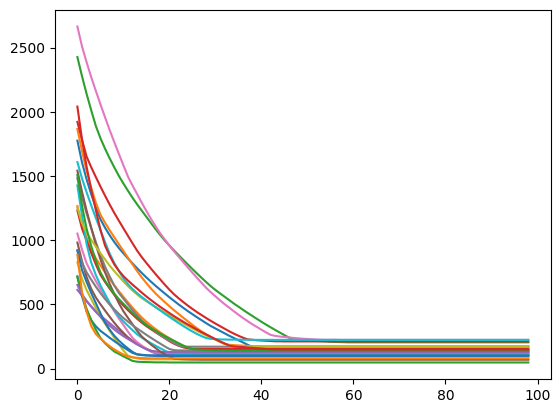

In [ ]:
for depot in depot_name:
  plt.plot(depotToBuses[depot])

In [ ]:
iv = []
for cc in range(300, 740):
  totalChargers = cc
  inventory = 0
  chargerDepot = {}
  for depot in depot_name:
    c = depotToBuses[depot][2:8].index(max(depotToBuses[depot][2:8]))
    inventory += (depotToBuses[depot][c+2])
    chargerDepot[depot] = c+2
    totalChargers -= c+2
    # print(chargerDepot[depot], depot, totalChargers)
  while totalChargers>0:
    dec = 0
    m = 'Colaba depot'
    # print(totalCharher)
    for depot in depot_name:
      # print(chargerDepot[depot], depot)
      if depotToBuses[depot][chargerDepot[depot]] - depotToBuses[depot][chargerDepot[depot]+1] >= dec:
        dec = depotToBuses[depot][chargerDepot[depot]] - depotToBuses[depot][chargerDepot[depot]+1]
        m = depot
    totalChargers -= 1
    chargerDepot[m] += 1
  inv = 0
  for depot in depot_name:
    inv += depotToBuses[depot][chargerDepot[depot]]

  iv.append(inv)

  # print(totalChargers)

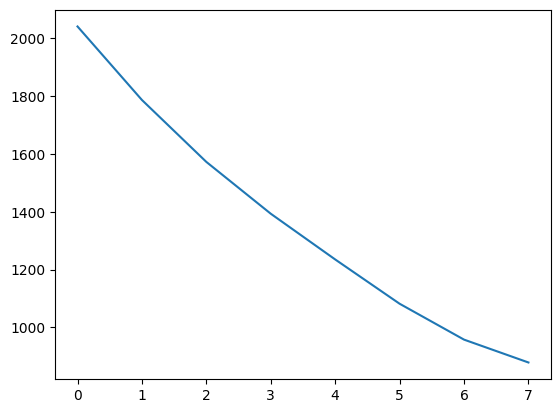

In [ ]:
plt.plot(depotToBuses['Mulund depot'][:8])

In [ ]:
len(iv)

440

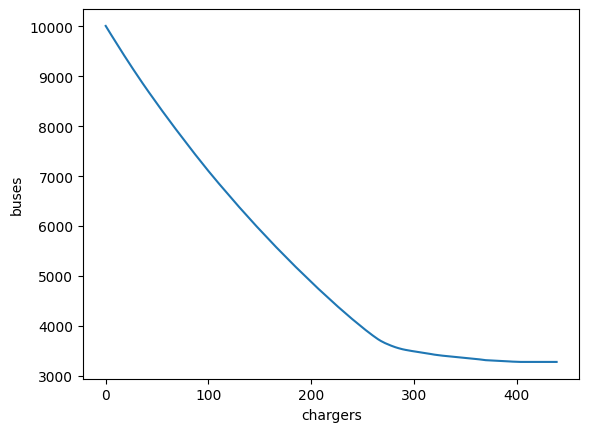

In [ ]:
plt.plot(iv)
plt.xlabel('chargers')
plt.ylabel('buses')
plt.show()

In [ ]:
for i in range(300, 740, 20):
  print(iv[i-300])

10011
9355
8741
8169
7623
7103
6615
6149
5704
5282
4879
4496
4135
3806
3585
3488
3422
3377
3336
3301
3278
3276


In [ ]:
for i in range(300, 720, 20):
  print(i)

In [ ]:
iv[439]

3276

In [ ]:
depotToBuses

defaultdict(<function __main__.<lambda>()>,
            {'Colaba depot': [1775,
              1606,
              1474,
              1358,
              1257,
              1163,
              1097,
              1039,
              986,
              939,
              897,
              857,
              818,
              780,
              744,
              709,
              676,
              644,
              614,
              584,
              555,
              527,
              499,
              473,
              447,
              423,
              399,
              376,
              353,
              331,
              312,
              293,
              274,
              255,
              238,
              220,
              203,
              185,
              169,
              154,
              150,
              146,
              143,
              139,
              137,
              134,
              131,
              128,
              126,
 

In [ ]:
df = pd.DataFrame(data=depotToBuses)

df = (df)

print (df)

df.to_excel('dict1.xlsx')

    Colaba depot  Backbay depot  Mumbai Central depot  Worli depot  \
0           1775           1265                  2426         1231   
1           1606           1118                  2277         1091   
2           1474           1019                  2139          995   
3           1358            927                  2012          901   
4           1257            859                  1890          812   
..           ...            ...                   ...          ...   
94           124            144                   204          153   
95           124            144                   204          153   
96           124            144                   204          153   
97           124            144                   204          153   
98           124            144                   204          153   

    KalaKilla depot  Wadala depot  Dharavi depot  Dindoshi depot  Kurla depot  \
0               612           981           1051            1481          827 